09/12/2020

# About
Note, for all ReFeX features, we used the unionized features.

In [1]:
from __future__ import division
import os
import os
import itertools
#import community
from datetime import datetime, timedelta
from sklearn.model_selection import RandomizedSearchCV


folder_directory =os.getcwd()
os.chdir(folder_directory)
execfile('python_libraries.py')
execfile('parsing.py')  # Sam Way's Code
execfile('mixing.py')   # Sam Way's Code
execfile('create_adjacency_matrix.py')
execfile('LINK.py')


np.seterr(divide='ignore', invalid='ignore')

/Users/kristen/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))


# Across-Network (Replicate RolX Results + Baseline)


In [3]:
## 8/21/2018 - set up logforest model
from sklearn.ensemble import BaggingClassifier

In [4]:
subset_dates = np.array(['7_2004.csv',
                        '8_2004.csv',
                        '9_2004.csv',
                        '10_2004.csv',
                        '11_2004.csv',
                        '12_2004.csv',
                        '1_2005.csv',
                        '2_2005.csv',
                        '3_2005.csv',
                        '4_2005.csv',
                        '5_2005.csv',
                        '6_2005.csv'])

### AUC

In [5]:
from sklearn.model_selection import RandomizedSearchCV


In [6]:
## redo
y = pd.read_csv('../../data/RealityMining/convert_bluetooth_nw/by_month/labels.csv')

class_type = 'sloan' # mlgrad sloan

if class_type =='sloan':
    y['y']=((y.affil_clean=='sloan') | (y.affil_clean=='sloan_2'))+0
if class_type == 'mlgrad':
    y['y']=((y.affil_clean=='mlgrad') | (y.affil_clean=='1styeargrad') | (y.affil_clean=='grad '))+0


df_results = pd.DataFrame()
undersample = False


for iter_type in np.array([100,1,2,3]):
    print 'iter: ', iter_type
    print type(iter_type)
    
    ## accuracy
    acc_generic = []
    acc_generic_refex_predict = []

    ## auc
    auc_generic = []
    auc_generic_refex_predict = []


    

    for j in range(len(subset_dates)-1):
        if iter_type == 1:
            x_train = pd.read_csv('../refex-rolx-master-1/RM-data/out_union_0.5_RealityMining_'+subset_dates[j]+'-featureValues.csv', header = -1)
            print(np.shape(x_train))
            x_test = pd.read_csv('../refex-rolx-master-1/RM-data/out_union_0.5_RealityMining_'+subset_dates[j+1]+'-featureValues.csv', header = -1)
        if iter_type == 2:
            x_train = pd.read_csv('../refex-rolx-master-2/RM-data/out_union_0.5_RealityMining_'+subset_dates[j]+'-featureValues.csv', header = -1)
            x_test = pd.read_csv('../refex-rolx-master-2/RM-data/out_union_0.5_RealityMining_'+subset_dates[j+1]+'-featureValues.csv', header = -1)
        if iter_type == 3:
            x_train = pd.read_csv('../refex-rolx-master-3/RM-data/out_union_0.5_RealityMining_'+subset_dates[j]+'-featureValues.csv', header = -1)
            x_test = pd.read_csv('../refex-rolx-master-3/RM-data/out_union_0.5_RealityMining_'+subset_dates[j+1]+'-featureValues.csv', header = -1)
        if iter_type == 100:
            x_train = pd.read_csv('../refex-rolx-master/RM-data/out_union_0.5_RealityMining_'+subset_dates[j]+'-featureValues.csv', header = -1)
            x_test = pd.read_csv('../refex-rolx-master/RM-data/out_union_0.5_RealityMining_'+subset_dates[j+1]+'-featureValues.csv', header = -1)
 


        
        ##
        ## Baseline Classifier -- based on relative training proportions
        ## 
        
        df_train = pd.DataFrame({'id':np.array(map(np.int,x_train[0]))})
        df_test = pd.DataFrame({'id':np.array(map(np.int,x_test[0]))})

        y_train = df_train.merge(y[['id','y']],
                how = 'left',
                on = 'id')

        y_test = df_test.merge(y[['id','y']],
            how = 'left',
            on = 'id')

        num1 = np.sum(y_train.y==1)
        num0 = np.sum(y_train.y==0)
        if num1 > num0:
            label = 1
        else:
            label = 0


        y_predict = np.repeat(label,len(y_test))
        y_true = np.array(y_test.y)

        acc_generic.append(np.mean(y_true == y_predict))
        
        
        auc_generic.append(metrics.roc_auc_score(label_binarize(y_true,np.unique(y_true)),
                                                                            y_predict,average='weighted'))

        ## 1st column is an IDs column -- we drop
        x_train = x_train.loc[:,1::]
        x_test = x_test.loc[:,1::]
        
        
        ## next we need to align columns -- want intersection set of columns that are in both training and test months
        if iter_type == 100:
            x_train_names = pd.read_csv('../refex-rolx-master/RM-data/union_unique_featureNames.csv')
            x_test_names = pd.read_csv('../refex-rolx-master/RM-data/union_unique_featureNames.csv')

        if iter_type == 1 or iter_type == 2 or iter_type ==3:
            x_train_names = pd.read_csv('../refex-rolx-master-'+str(iter_type) +'/RM-data/union_unique_featureNames.csv')
            x_test_names = pd.read_csv('../refex-rolx-master-'+str(iter_type) +'/RM-data/union_unique_featureNames.csv')


        
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)

        scaler.fit(x_test)
        x_test = scaler.transform(x_test)
        
        
        x_train_m = pd.DataFrame(np.matrix(x_train))
        x_test_m = pd.DataFrame(np.matrix(x_test))
        x_train_m.columns = np.array(x_train_names.columns)
        x_test_m.columns = np.array(x_test_names.columns)

        arg_sort_idx = np.array(x_train_m.columns).argsort()
        x_train_m = x_train_m.iloc[:,arg_sort_idx]
        x_test_m = x_test_m.iloc[:,arg_sort_idx]
        num_features = np.shape(x_train_m)[1]

        C_vals = [10**x for x in range(-10,100)]
        model = linear_model.LogisticRegressionCV(
                                   Cs = C_vals,
                                   penalty='l2',
                                    solver='lbfgs',
                                   cv = 5, max_iter = 5000)


        model.fit(x_train_m,
              y_train.y)

        y_predict_refex = model.predict(x_test_m)
        acc_generic_refex_predict.append(np.mean(y_true == y_predict_refex))

        y_predict_refex = model.predict_proba(x_test_m)[:,1]
        #print model.predict_proba(x_test_m)[:,1]
        #print ''
        auc_generic_refex_predict.append(metrics.roc_auc_score(label_binarize(y_true,np.unique(y_true)),
                                                                            y_predict_refex,average='weighted'))


    df_results['iter_type_'+str(iter_type)] = acc_generic_refex_predict
    df_results['iter_type_auc_'+str(iter_type)] = auc_generic_refex_predict




iter:  100
<type 'numpy.int64'>
iter:  1
<type 'numpy.int64'>
(30, 6)
(45, 6)
(89, 6)
(82, 6)
(89, 6)
(90, 6)
(88, 6)
(81, 6)
(79, 6)
(73, 6)
(63, 6)
iter:  2
<type 'numpy.int64'>
iter:  3
<type 'numpy.int64'>


In [7]:
x_labels = np.array(['Jul-04',
                        'Aug-04',
                        'Sep-04',
                        'Oct-04',
                        'Nov-04',
                        'Dec-04',
                        'Jan-05',
                        'Feb-05',
                        'Mar-05',
                        'Apr-05',
                        'May-05',
                        'June-05'])

## Add in LINK results

In [8]:
edges_setup = pd.read_csv('../../data/RealityMining/convert_bluetooth_nw/by_month/all_months_years.csv', header = -1)
df = pd.crosstab(edges_setup[0], edges_setup[1])
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
df.head()

,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,...,95.0,96.0,97.0,98.0,99.0,100.0,101.0,102.0,103.0,105.0
2.0,0,1,1,1,1,1,1,1,1,1,...,1,0,0,1,1,1,1,1,1,1
3.0,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4.0,1,1,0,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
5.0,1,1,1,0,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
6.0,1,1,1,1,0,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1


In [9]:
edges_setup.columns = ['source','target','link']


In [10]:
G = nx.from_pandas_edgelist(edges_setup,source='source', target='target',
                           create_using = nx.Graph())


adj_LINK = nx.adjacency_matrix(G, nodelist = G.nodes()).todense()
tmp = pd.DataFrame(np.array(G.nodes())) # note ordering of adjacency matrix is produced by G.nodes()
tmp.columns = ['keys']
print(len(tmp))

y_train_y = pd.read_csv('../../data/RealityMining/convert_bluetooth_nw/by_month/labels.csv')
y_train_y.columns = ['keys','gender_y']

tmp = tmp.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')


93


In [11]:
total_keys = np.unique(tmp['keys'])

In [12]:
## TRAIN
edges_setup = pd.read_csv('../../data/RealityMining/convert_bluetooth_nw/by_month/7_2004.csv', header = -1)
df = pd.crosstab(edges_setup[0], edges_setup[1])
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
df.head()
edges_setup.columns = ['source','target','link']
G = nx.from_pandas_edgelist(edges_setup,source='source', target='target',
                           create_using = nx.Graph())


adj_LINK = nx.adjacency_matrix(G, nodelist = G.nodes()).todense()
tmp = pd.DataFrame(np.array(G.nodes())) # note ordering of adjacency matrix is produced by G.nodes()
tmp.columns = ['keys']
print(len(tmp))

y_train_y = pd.read_csv('../../data/RealityMining/convert_bluetooth_nw/by_month/labels.csv')
if class_type =='sloan':
    y_train_y['gender_y']=((y_train_y.affil_clean=='sloan') | (y_train_y.affil_clean=='sloan_2'))+0


y_train_y.columns = ['keys','affil_clean','gender_y']

tmp = tmp.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')


30


In [13]:
edges_calls = pd.read_csv('../../data/RealityMining/convert_bluetooth_nw/by_month/8_2004.csv',
                   header = None)

df_calls = pd.crosstab(edges_calls[0], edges_calls[1])
idx = df_calls.columns.union(df_calls.index)
df_calls = df_calls.reindex(index = idx, columns=idx, fill_value=0)


edges_calls.columns = ['source','target','link']
G = nx.from_pandas_edgelist(edges_calls,source='source', target='target')


adj_LINK_calls = nx.adjacency_matrix(G).todense()
tmp_calls = pd.DataFrame(np.array(G.nodes())) # note ordering of adjacency matrix is produced by G.nodes()
tmp_calls.columns = ['keys']
print(len(tmp_calls))
print(tmp_calls.head())
tmp_calls = tmp_calls.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')


45
   keys
0   2.0
1   3.0
2   4.0
3   5.0
4   6.0


In [14]:
add_null = total_keys[~np.in1d(total_keys,np.array(tmp['keys']))]
adj_LINK_total = np.concatenate((adj_LINK, np.zeros((len(tmp['keys']), len(add_null)))),
               axis = 1)

idx_col = np.argsort(np.concatenate((np.array(tmp['keys']), add_null)))
adj_LINK_total = adj_LINK_total[:,idx_col]

In [15]:
add_null = total_keys[~np.in1d(total_keys,np.array(tmp_calls['keys']))]


adj_LINK_calls_total = np.concatenate((adj_LINK_calls, np.zeros((len(tmp_calls['keys']), len(add_null)))),
               axis = 1)

In [16]:
idx_col = np.argsort(np.concatenate((np.array(tmp_calls['keys']), add_null)))

adj_LINK_calls_total = adj_LINK_calls_total[:,idx_col]

In [17]:
C_vals = [10**x for x in range(-10,100)]
model = linear_model.LogisticRegressionCV(
                                   Cs = C_vals,
                                   penalty='l2',
                                    solver='lbfgs',
                                   cv = 5, max_iter = 5000)

model.fit(adj_LINK_total,
              tmp.gender_y)


y_predict_refex = model.predict_proba(adj_LINK_calls_total)[:,1]
print('auc: ',metrics.roc_auc_score(label_binarize(tmp_calls.gender_y,np.unique(tmp_calls.gender_y)),
                                 y_predict_refex,average='weighted'))



('auc: ', 0.9590336134453782)


## Iterate through

In [18]:
auc_link = []
for j in range(len(subset_dates)-1):
    print(subset_dates[j+1])
    
  ## TRAIN
    edges_setup = pd.read_csv('../../data/RealityMining/convert_bluetooth_nw/by_month/'+subset_dates[j], header = -1)
    df = pd.crosstab(edges_setup[0], edges_setup[1])
    idx = df.columns.union(df.index)
    df = df.reindex(index = idx, columns=idx, fill_value=0)
    edges_setup.columns = ['source','target','link']
    G = nx.from_pandas_edgelist(edges_setup,source='source', target='target',
                               create_using = nx.Graph())


    adj_LINK = nx.adjacency_matrix(G, nodelist = G.nodes()).todense()
    tmp = pd.DataFrame(np.array(G.nodes())) # note ordering of adjacency matrix is produced by G.nodes()
    tmp.columns = ['keys']
    print(len(tmp))

    y_train_y = pd.read_csv('../../data/RealityMining/convert_bluetooth_nw/by_month/labels.csv')
    if class_type =='sloan':
        y_train_y['gender_y']=((y_train_y.affil_clean=='sloan') | (y_train_y.affil_clean=='sloan_2'))+0


    y_train_y.columns = ['keys','affil_clean','gender_y']

    tmp = tmp.merge(y_train_y[['keys','gender_y']],
            how = 'left',
            on = 'keys')
    
    #Test
    edges_calls = pd.read_csv('../../data/RealityMining/convert_bluetooth_nw/by_month/'+subset_dates[j+1],
                   header = None)

    df_calls = pd.crosstab(edges_calls[0], edges_calls[1])
    idx = df_calls.columns.union(df_calls.index)
    df_calls = df_calls.reindex(index = idx, columns=idx, fill_value=0)


    edges_calls.columns = ['source','target','link']
    G = nx.from_pandas_edgelist(edges_calls,source='source', target='target')


    adj_LINK_calls = nx.adjacency_matrix(G).todense()
    tmp_calls = pd.DataFrame(np.array(G.nodes())) # note ordering of adjacency matrix is produced by G.nodes()
    tmp_calls.columns = ['keys']

    tmp_calls = tmp_calls.merge(y_train_y[['keys','gender_y']],
            how = 'left',
            on = 'keys')
    add_null = total_keys[~np.in1d(total_keys,np.array(tmp['keys']))]
    adj_LINK_total = np.concatenate((adj_LINK, np.zeros((len(tmp['keys']), len(add_null)))),
                   axis = 1)

    idx_col = np.argsort(np.concatenate((np.array(tmp['keys']), add_null)))
    adj_LINK_total = adj_LINK_total[:,idx_col]
    
    add_null = total_keys[~np.in1d(total_keys,np.array(tmp_calls['keys']))]


    adj_LINK_calls_total = np.concatenate((adj_LINK_calls, np.zeros((len(tmp_calls['keys']), len(add_null)))),
               axis = 1)
    
    idx_col = np.argsort(np.concatenate((np.array(tmp_calls['keys']), add_null)))

    adj_LINK_calls_total = adj_LINK_calls_total[:,idx_col]
    
    C_vals = [10**x for x in range(-10,100)]
    model = linear_model.LogisticRegressionCV(
                                       Cs = C_vals,
                                       penalty='l2',
                                        solver='lbfgs',
                                       cv = 5, max_iter = 5000)

    model.fit(adj_LINK_total,
                  tmp.gender_y)


    y_predict_refex = model.predict_proba(adj_LINK_calls_total)[:,1]
    print('auc: ',metrics.roc_auc_score(label_binarize(tmp_calls.gender_y,np.unique(tmp_calls.gender_y)),
                                     y_predict_refex,average='weighted'))

    auc_link.append(metrics.roc_auc_score(label_binarize(tmp_calls.gender_y,np.unique(tmp_calls.gender_y)),
                                     y_predict_refex,average='weighted'))

8_2004.csv
30
('auc: ', 0.9590336134453782)
9_2004.csv
45
('auc: ', 0.9285714285714286)
10_2004.csv
89
('auc: ', 0.9985261606484893)
11_2004.csv
82
('auc: ', 1.0)
12_2004.csv
89
('auc: ', 0.9993846153846154)
1_2005.csv
90
('auc: ', 0.9986622073578596)
2_2005.csv
88
('auc: ', 1.0)
3_2005.csv
81
('auc: ', 0.9975369458128078)
4_2005.csv
79
('auc: ', 0.9941520467836257)
5_2005.csv
73
('auc: ', 0.9925925925925926)
6_2005.csv
63
('auc: ', 1.0)


In [21]:
x_labels

array(['Jul-04', 'Aug-04', 'Sep-04', 'Oct-04', 'Nov-04', 'Dec-04',
       'Jan-05', 'Feb-05', 'Mar-05', 'Apr-05', 'May-05', 'June-05'],
      dtype='|S7')

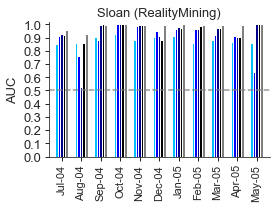

In [19]:
from matplotlib.backends.backend_pdf import PdfPages

alpha_empirical = 0.4

%matplotlib inline
nbins = 45
f, (ax1) = plt.subplots(1, 1, 
                             sharey=False, sharex=False,
                            figsize=(4,3))
plt.setp(ax1, xticks=[ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ], 
         xticklabels=x_labels)
plt.setp(ax1.get_xticklabels(), rotation=90,
        size =13)

#ax1.set_xticks([0,0.25, 0.5, 0.75, 1])
ax1.minorticks_on()
ax1.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0, labelsize = 11)
plt.axhline(0.5, color='gray', linestyle='--', alpha = 0.5)


w = 1.5
width = 0.2
#ax1.bar(np.array(range(len(acc_generic)))*w+0.4,auc_generic, color = 'red', #alpha = 0.5,
#        #align = 'right',
#       width = width, edgecolor = 'white')
#
ax1.bar(np.array(range(len(df_results)))*w-0.4,df_results.iter_type_auc_1, color = 'deepskyblue',# alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')
ax1.bar(np.array(range(len(df_results)))*w-0.2,df_results.iter_type_auc_2, color = 'blue', #alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')
ax1.bar(np.array(range(len(df_results)))*w-0,df_results.iter_type_auc_3, color = 'darkblue', #alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')
ax1.bar(np.array(range(len(df_results)))*w+0.2,df_results.iter_type_auc_100, color = 'black', #alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')
ax1.bar(np.array(range(len(auc_link)))*w+0.4,auc_link, color = 'gray', #alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')

ax1.set_ylabel('AUC', size = 13)

ax1.set_xlim(-1.5,np.max(np.array(range(len(acc_generic)))*w)+1.5)
ax1.set_ylim(0,1.02)
plt.yticks(np.arange(0,1.02,0.1), size = 13)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_xlim(-1,16)


if class_type == 'sloan':
    plt.title('Sloan (RealityMining)', size = 13)

plt.axhline(0.5, color='gray', linestyle='--', alpha = 0.5)

plt.tight_layout()


#if class_type == 'sloan':
#    if undersample:
#        pp = PdfPages('../../figs/NEWsloan_refex_AUC_undersample_simods.pdf')
#    else:
#        pp = PdfPages('../../figs/NEWsloan_refex_AUC_final_simods.pdf')
#pp.savefig()
#pp.close()

In [27]:
x_labels[0:11]

array(['Jul-04', 'Aug-04', 'Sep-04', 'Oct-04', 'Nov-04', 'Dec-04',
       'Jan-05', 'Feb-05', 'Mar-05', 'Apr-05', 'May-05'], dtype='|S7')

In [28]:
df_results = pd.DataFrame({'test': x_labels[0:11],
                           'refex-1': df_results.iter_type_auc_1,
                           'refex-2': df_results.iter_type_auc_2,
                           'refex-3': df_results.iter_type_auc_3,
                           'refex-max': df_results.iter_type_auc_100,
                           'auc_LINK': auc_link,
                            })
df_results.to_csv('NEWRMAcrossResultsICWSMRevision.csv',sep=',', index = False)

### Accuracy

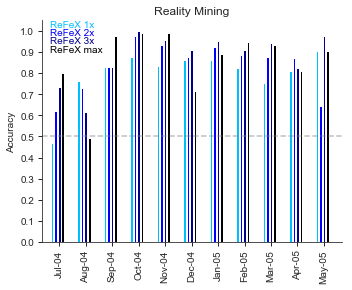

sloan
undersample:  False


In [14]:
from matplotlib.backends.backend_pdf import PdfPages

alpha_empirical = 0.4

%matplotlib inline
nbins = 45
f, (ax1) = plt.subplots(1, 1, 
                             sharey=False, sharex=False,
                            figsize=(5, 4))
plt.setp(ax1, xticks=[ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ], 
         xticklabels=x_labels)
plt.setp(ax1.get_xticklabels(), rotation=90)

#ax1.set_xticks([0,0.25, 0.5, 0.75, 1])
ax1.minorticks_on()
ax1.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)

w = 1.5
width = 0.15
#ax1.bar(np.array(range(len(acc_generic)))*w+0.4,acc_generic, color = 'red', #alpha = 0.5,
#        #align = 'right',
#       width = width, edgecolor = 'white')

ax1.bar(np.array(range(len(df_results)))*w-0.4,df_results.iter_type_1, color = 'deepskyblue',# alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')
ax1.bar(np.array(range(len(df_results)))*w-0.2,df_results.iter_type_2, color = 'blue', #alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')
ax1.bar(np.array(range(len(df_results)))*w-0,df_results.iter_type_3, color = 'darkblue', #alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')
ax1.bar(np.array(range(len(df_results)))*w+0.2,df_results.iter_type_100, color = 'black', #alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')
ax1.set_ylabel('Accuracy')
ax1.set_xlim(-1,np.max(np.array(range(len(acc_generic)))*w)+1)
ax1.set_ylim(0,1.05)
plt.yticks(np.arange(0,1.1,0.1))
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.set_xlim(-1,16)


ax1.annotate('ReFeX 1x', xy=(-0.5,1.02), 
                 color='deepskyblue', alpha=1, size=10)
ax1.annotate('ReFeX 2x', xy=(-0.5,1.02-0.04), 
                 color='blue', alpha=1, size=10)
ax1.annotate('ReFeX 3x', xy=(-0.5,1.02-0.04*2), 
                 color='darkblue', alpha=1, size=10)
ax1.annotate('ReFeX max', xy=(-0.5,1.02-0.04*3), 
                 color='black', alpha=1, size=10)
#ax1.annotate('Baseline', xy=(2.5,1.02), 
#                 color='red', alpha=1, size=7)
plt.tight_layout()
plt.axhline(0.5, color='gray', linestyle='--', alpha = 0.5)


plt.title('Reality Mining')
plt.show()
print class_type
print 'undersample: ', undersample

# Within-Network 

See other notebook.